# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


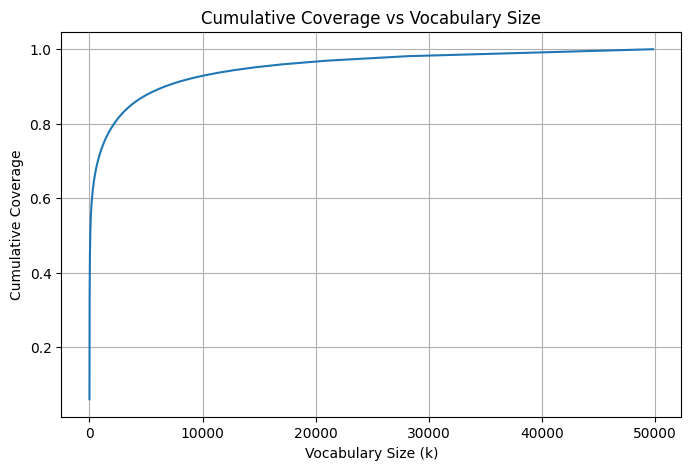

Total unique words in corpus: 49815
Minimal vocabulary size covering at least 90%: 6671
Coverage at k=6671: 0.9000


In [11]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Download Brown corpus if not already downloaded
nltk.download('brown')
from nltk.corpus import brown

# 1. Load Brown corpus
words = brown.words()

# Convert words to lowercase to avoid duplicates like "The" and "the"
words = [word.lower() for word in words]

# Count word frequencies
word_freq = Counter(words)

# Total number of tokens in corpus
total_tokens = sum(word_freq.values())

# Sort words by frequency (descending)
sorted_freqs = sorted(word_freq.values(), reverse=True)

# Compute cumulative coverage
cumulative_freqs = np.cumsum(sorted_freqs)
coverage = cumulative_freqs / total_tokens

# Vocabulary sizes
vocab_sizes = np.arange(1, len(sorted_freqs) + 1)

# 2. Plot cumulative coverage vs vocabulary size
plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, coverage)
plt.xlabel("Vocabulary Size (k)")
plt.ylabel("Cumulative Coverage")
plt.title("Cumulative Coverage vs Vocabulary Size")
plt.grid(True)
plt.show()

# 3. Select minimal vocabulary size covering at least 90%
threshold = 0.9
k_90 = np.argmax(coverage >= threshold) + 1  # +1 because index starts from 0

print(f"Total unique words in corpus: {len(sorted_freqs)}")
print(f"Minimal vocabulary size covering at least 90%: {k_90}")
print(f"Coverage at k={k_90}: {coverage[k_90-1]:.4f}")


## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [12]:
from collections import defaultdict, Counter
from tqdm import tqdm


class BPETokenizer:
    """ BPE tokenizer."""

    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.merges = []
        self.bpe_ranks = {}

    def train(self, corpus):
        # Build initial word frequencies
        word_freqs = Counter()
        for line in corpus:
            words = line.strip().split()
            for word in words:
                word_freqs[word] += 1

        # Initialize vocab: character sequences
        vocab = {}
        for word, freq in word_freqs.items():
            vocab[tuple(word) + ("</w>",)] = freq

        # Initial symbols count
        symbols = set()
        for word in vocab:
            symbols.update(word)

        num_merges = self.vocab_size - len(symbols)

        # Use tqdm for progress bar
        for i in tqdm(range(num_merges), desc="Training BPE"):
            # Count pairs
            pairs = defaultdict(int)
            for word, freq in vocab.items():
                for j in range(len(word) - 1):
                    pairs[(word[j], word[j + 1])] += freq

            if not pairs:
                break

            best_pair = max(pairs, key=pairs.get)
            self.merges.append(best_pair)
            self.bpe_ranks[best_pair] = i

            # Apply merge
            new_vocab = {}
            pair_str = f"{best_pair[0]} {best_pair[1]}"
            merged = best_pair[0] + best_pair[1]

            for word, freq in vocab.items():
                word_str = " ".join(word)
                new_word = tuple(word_str.replace(pair_str, merged).split())
                new_vocab[new_word] = freq

            vocab = new_vocab

    def tokenize(self, text):
        """
        Tokenize input text using learned BPE merges.

        Parameters
        text : str
            Input sentence.

        Returns
        tokens : list of str
            List of subword tokens.
        """
        tokens = []

        words = text.strip().split()

        for word in words:
            # Initialize word as character sequence + </w>
            word_symbols = list(word) + ["</w>"]

            # Apply merges in learned order
            while True:
                pairs = [(word_symbols[i], word_symbols[i + 1])
                         for i in range(len(word_symbols) - 1)]

                # Find mergeable pairs
                candidate_pairs = [
                    pair for pair in pairs if pair in self.bpe_ranks
                ]

                if not candidate_pairs:
                    break

                # Choose pair with smallest rank
                best_pair = min(candidate_pairs,
                                key=lambda p: self.bpe_ranks[p])

                i = 0
                new_symbols = []

                while i < len(word_symbols):
                    if (i < len(word_symbols) - 1 and
                        (word_symbols[i], word_symbols[i + 1]) == best_pair):
                        new_symbols.append(word_symbols[i] + word_symbols[i + 1])
                        i += 2
                    else:
                        new_symbols.append(word_symbols[i])
                        i += 1

                word_symbols = new_symbols

            # Remove end-of-word token
            if word_symbols[-1] == "</w>":
                word_symbols = word_symbols[:-1]

            tokens.extend(word_symbols)

        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [13]:
import numpy as np
from collections import Counter

# 1. Train the BPETokenizer on the Brown corpus with the appropriate vocabulary size
vocab_size = k_90
tokenizer = BPETokenizer(vocab_size=vocab_size)

# Corpus preparation: take the first 1000 sentences from the Brown corpus
corpus_1000 = [" ".join(brown.sents()[:1000][i]) for i in range(1000)]
full_corpus =[" ".join(sent) for sent in brown.sents()]
# Training the tokenizer
tokenizer.train(full_corpus)

# 2. Calculate mean and standard deviation of tokenizer's fertility and tokenized sentence length

# Function for calculating fertility: number of tokens / number of words
def calculate_fertility(tokenizer, sentences):
    fertilities = []
    for sentence in sentences:
        words = sentence.strip().split()
        tokens = tokenizer.tokenize(sentence)
        fertility = len(tokens) / len(words) if words else 0
        fertilities.append(fertility)
    return fertilities

# Function for calculating the length of a tokenized sentence
def calculate_tokenized_lengths(tokenizer, sentences):
    lengths = []
    for sentence in sentences:
        tokens = tokenizer.tokenize(sentence)
        lengths.append(len(tokens))
    return lengths

# Calculate fertility and lengths
fertilities = calculate_fertility(tokenizer, corpus_1000)
tokenized_lengths = calculate_tokenized_lengths(tokenizer, corpus_1000)

# Mean and standard deviation
fertility_mean = np.mean(fertilities)
fertility_std = np.std(fertilities)
length_mean = np.mean(tokenized_lengths)
length_std = np.std(tokenized_lengths)

print(f"Fertility: Mean = {fertility_mean:.4f}, Std = {fertility_std:.4f}")
print(f"Tokenized Length: Mean = {length_mean:.4f}, Std = {length_std:.4f}")


Training BPE: 100%|██████████| 6587/6587 [11:13<00:00,  9.77it/s]


Fertility: Mean = 2.4037, Std = 0.5655
Tokenized Length: Mean = 51.9710, Std = 29.5944


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.